In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Let's generate random sine waves
Our goal is to train a model which can create sine waves of frequencies and phases. The model has to figure out the frequency and phase using the given input and then indefinitely create the wave. 
For this our model needs to be trained on wide variety of sine waves. Here we set our model parameters as given in the first four lines and then the input/output are generated accordingly.

In [2]:
SEQ_LEN = 128
BATCH_SIZE = 32
LSTM_SIZE = 100
LOOK_BACK = 10

def create_batches(batch_size=BATCH_SIZE, look_back=LOOK_BACK, seq_len=SEQ_LEN):
    T = np.linspace(-3, 3, num=seq_len+1+look_back)
    freqs = np.random.randint(1, 3.1, batch_size)
    phases = np.random.randn(batch_size)
    X = np.zeros((batch_size, seq_len, look_back))
    Y = np.zeros((batch_size, seq_len, 1))
    for i in range(batch_size):
        for j in range(len(T)-look_back-1):
            X[i, j, :] = np.sin(freqs[i]*T[j:(j+look_back)]+phases[i])
            Y[i, j, 0] = np.sin(freqs[i]*T[j+look_back]+phases[i])
    
    return(X, Y)

In [3]:
x, y = create_batches()
x.shape, y.shape

((32, 128, 10), (32, 128, 1))

## We visualize one of the random inputs

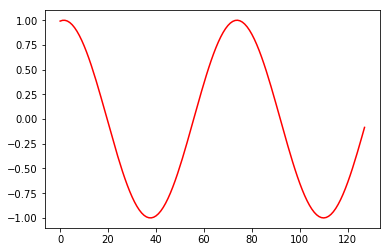

In [4]:
ind = np.random.randint(BATCH_SIZE)
plt.plot(y[ind,:,0], color='r')

In [5]:
from keras.layers import Dense, Dropout
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.models import Sequential

Using TensorFlow backend.


## Model creation
Here we create the architecture of RNN. Note that we shall use different input shape for training and testing (Since in testing all we might have are the signals of the first few time steps. So both our batch_size and seq_len are 1 for testing. We simply train on a train_model and reuse those weights in the test_model

In [6]:
def make_RNN(train=True):
    if train:
        my_batch_input_shape = (BATCH_SIZE, SEQ_LEN, LOOK_BACK)
    else:
        my_batch_input_shape = (1, 1, LOOK_BACK)
    model = Sequential()
    model.add(Dropout(0.1, batch_input_shape=my_batch_input_shape))
    model.add(LSTM(LSTM_SIZE, return_sequences=True, stateful=True))
    model.add(Dropout(0.5))
    model.add(LSTM(LSTM_SIZE, return_sequences=True, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return(model)

In [7]:
train_model = make_RNN()

#### If the loss doesn't decrease by a threshold then it is time to reduce the learning rate. This is done using the following function. 

In [8]:
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor='loss', 
                               factor=0.1, 
                               patience=10, 
                               verbose=0, 
                               mode='auto', 
                               epsilon=0.001, 
                               cooldown=0, 
                               min_lr=1e-7)

loss: 0.00426916752476: 100%|██████████████████████████████████████████████████████| 1000/1000 [07:33<00:00,  2.15it/s]


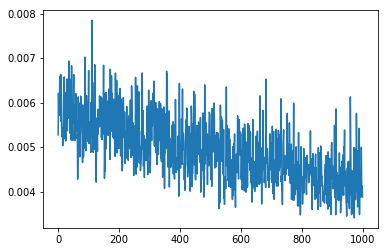

In [10]:
history = []
from tqdm import trange
iters = trange(1000)
for i in iters:
    X, y = create_batches()
    hist = train_model.fit(X, y, batch_size=BATCH_SIZE, verbose=0, epochs=1, callbacks=[lr_reducer])
    history.extend(hist.history['loss'])
    if i%5 == 0:
        iters.set_description('loss: '+str(np.mean(history[-10:])))
plt.plot(history)

In [11]:
test_model = make_RNN(train=False)
test_model.reset_states()
test_model.set_weights(train_model.get_weights())

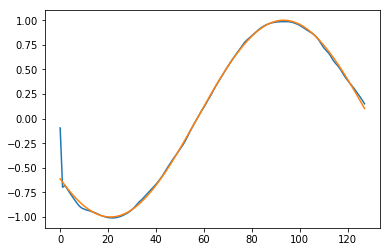

In [12]:
x, y_ = create_batches()
preds = train_model.predict(x, verbose=0)
plt.plot(preds[0])
plt.plot(y_[0])

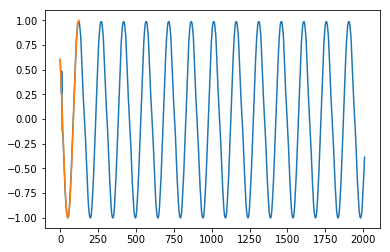

In [13]:
x, y_ = create_batches()
x = np.zeros((1, 1, LOOK_BACK))
y = y_[0, :, 0]
x[0, 0, :] = y[:LOOK_BACK]
out = []
out.extend(x[0,0])
for i in range(2000):
    pred = test_model.predict(x)[0, 0, 0]
    x[0, 0, :-1] = x[0, 0, 1:]
    if i < 20:
        x[0, 0, -1] = y[LOOK_BACK+i]
    else:
        x[0, 0, -1] = pred
    out.append(pred)
    
plt.plot(out)
plt.plot(y)

## Saving Progress
Finally the way to save the model is using the following function

In [14]:
train_model.save_weights('Train_model_SineWaves_LSTM.h5')